# Configuration

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10})

## Modules

In [ ]:
# Installing necessary modules
!pip install --upgrade pip
!pip install tqdm
!pip install gdown
!pip install chess
!pip install tensorflow
!pip install cairosvg

     |████████████████████████████████| 2.1 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import tqdm


In [4]:
#Loading tensorflow, checking that we have a GPU allocated
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

2022-02-13 19:45:36.570667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 19:45:36.625485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 19:45:36.680406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 19:45:36.681260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Constants

In [5]:
# Remote url for the dataset (for now has to be Google Drive)
DATA_URL = "https://drive.google.com/file/d/192Px9a5_LB_d1fRKK68ID_luRCMRhy3B/view?usp=sharing"
# Folders used for the extraction and pre-processing of the raw dataset
DATA_FILENAME = "data.zip"
DATA_FOLDER = "data"
TF_RECORDS_FOLDER = "tfrecords"
# Path of the file in which the config used for the renders (mainly the board characteristics actually...) is stored
CONFIG_FILE_PATH = os.path.join(DATA_FOLDER, "config.json")
# Size of the training images
IMAGE_SIZE = 128
BATCH_SIZE = 64
# Proportion of the data dedicated to validation
TRAIN_PROPORTION = 0.7
VAL_PROPORTION = 0.15
TEST_PROPORTION = 0.15
#Factor by which to increase the cropping zone of the board.
IMAGE_GROWTH_FACTOR = 0.1

# IO functions for the images and data
def getTFRecordPath(boardNum, cellName):
    return os.path.join(TF_RECORDS_FOLDER, "{}_{}.tfrec".format(boardNum, cellName))

def getImageConfigPath(imgNum):
    return os.path.join(DATA_FOLDER, "{}.json".format(imgNum))

def getRawImagePath(imgNum):
    return os.path.join(DATA_FOLDER, "{}.jpg".format(imgNum))

# Data Preprocessing

## Raw dataset extraction

### Downloading the raw dataset

In [ ]:
# Checking that the data has not been downloaded yet
if os.path.exists(DATA_FILENAME):
  print("File already exists, skipping download.")
else:
  # Downloading the data
  if DATA_URL.split("/")[2] == "drive.google.com":
    print("Detected Google Drive link for the data.")
    dataGdriveId = DATA_URL.split("/")[5]
    print("Downloading...")
    !gdown --id $dataGdriveId --output $DATA_FILENAME
    if not os.path.exists(DATA_FILENAME):
      raise Exception("Could not download the data from Google Drive. Maybe too many downloads ?")
  else:
    raise Exception("Downloading from sources other than Google Drive not supported yet.")
    #!curl -o data.zip DATA_URL

Detected Google Drive link for the data.
Downloading...
Downloading...
From: https://drive.google.com/uc?id=192Px9a5_LB_d1fRKK68ID_luRCMRhy3B
To: /content/data.zip
100% 457M/457M [00:03<00:00, 118MB/s]


### Unzipping into an appropriate folder

In [ ]:
if not os.path.exists(DATA_FOLDER):
  os.makedirs(DATA_FOLDER)
print("Unzipping downloaded data")
!unzip $DATA_FILENAME
!rm $DATA_FILENAME

Unzipping downloaded data
Archive:  data.zip
  inflating: data/250.json           
  inflating: data/248.json           
  inflating: data/245.json           
  inflating: data/242.json           
  inflating: data/239.jpg            
  inflating: data/238.jpg            
  inflating: data/234.jpg            
  inflating: data/231.jpg            
  inflating: data/230.jpg            
  inflating: data/228.jpg            
  inflating: data/223.jpg            
  inflating: data/221.jpg            
  inflating: data/220.jpg            
  inflating: data/214.json           
  inflating: data/212.json           
  inflating: data/211.jpg            
  inflating: data/210.jpg            
  inflating: data/208.jpg            
  inflating: data/206.json           
  inflating: data/205.json           
  inflating: data/204.jpg            
  inflating: data/202.jpg            
  inflating: data/200.json           
  inflating: data/198.jpg            
  inflating: data/197.jpg            
  inf

## Extracting the renders config

In [6]:
# Loading the types of pieces represented, as well as the cells and their coordinates
config = json.load(open(CONFIG_FILE_PATH, "r"))
piecesTypes = config['piecesTypes']
cellsCoordinates = config['cellsCoordinates']
cellsNames = list(cellsCoordinates.keys())

if not None in piecesTypes:
  piecesTypes = piecesTypes + [None]

# Finding the extent of the board
minCoords = np.array([np.inf, np.inf])
maxCoords = np.array([-np.inf, -np.inf])
for cellName in cellsCoordinates:
  minCoords = np.minimum(minCoords, cellsCoordinates[cellName])
  maxCoords = np.maximum(maxCoords, cellsCoordinates[cellName])

boardSize = (maxCoords - minCoords + np.array([1.0, 1.0])).astype(int)

marginsSize = np.array([1.0, 1.0]) * IMAGE_SIZE * IMAGE_GROWTH_FACTOR * 0.5
cellSize = (IMAGE_SIZE - 2.0 * marginsSize) / boardSize
cellRelSize = (1.0 - IMAGE_GROWTH_FACTOR) / boardSize

print("Cells names : ", cellsNames)
print("Pieces types : ", piecesTypes)
print("Board size : ", boardSize) 

Cells names :  ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8']
Pieces types :  ['bishop_b', 'bishop_w', 'king_b', 'king_w', 'knight_b', 'knight_w', 'pawn_b', 'pawn_w', 'queen_b', 'queen_w', 'rook_b', 'rook_w', None]
Board size :  [8 8]


## Formatting training data into TFRecords

In [16]:
"""
The images all contain pictures of a chess board at a somewhat overlooking angle. 
This is not likely to work for the model, which needs data to be in a very similar format.
We thus wrap the images into new ones where the corners of the board match the corner of the image, with a given scaling factor
"""

if not os.path.exists(TF_RECORDS_FOLDER):
  os.makedirs(TF_RECORDS_FOLDER)

def getSegmentsIntersection(a1, a2, b1, b2):
    """
    Computes the intersection of two segments : returns the intersection point if it exists, and None otherwise
    """
    a = a2 - a1
    b = b2 - b1
    o = a1 - b1
    aLenSq = np.dot(a, a)
    aDotB = np.dot(a, b)
    denom = (aLenSq * np.dot(b, b)) - aDotB**2.0

    if denom == 0.0:
        # The segment are parallel, no unique intersection exists
        return None

    u = ((aLenSq * np.dot(b, o)) - (aDotB * np.dot(a, o))) / denom

    if u < 0.0 or u > 1.0:
        # The potential intersection point is not situated on the segment, aborting
        return None

    t = np.dot(a, u * b - o) / aLenSq
    aPoint = a1 + t * a
    bPoint = b1 + u * b

    return aPoint if (np.linalg.norm(np.round(aPoint - bPoint), 5) == 0.0) else None

def unprojectCropFromRelativeCoords(img_, boardCornersRel, outputShape, growthFactor = 0.0):
    """
    Unprojects a four-sided area of an image, the coordinates of that area's corners being in relative space
    """
    O = getSegmentsIntersection(boardCornersRel[0], boardCornersRel[3], boardCornersRel[1], boardCornersRel[2])
    for i in range(4):
        boardCornersRel[i] = growthFactor * (boardCornersRel[i] - O) + boardCornersRel[i]

    cornersAbs = np.round(boardCornersRel * (np.array(img_.shape)[0:2] - np.array([1.0, 1.0])))

    outCoords = np.array([
        [outputShape[0]-1, 0.0],
        [outputShape[0]-1, outputShape[1]-1],
        [0.0, 0.0],
        [0.0, outputShape[1]-1],
    ])

    inCoords = np.float32(cornersAbs)
    outCoords = np.float32(outCoords)
    M = cv2.getPerspectiveTransform(inCoords, outCoords)

    return cv2.warpPerspective(img_, M, outputShape, flags=cv2.INTER_LINEAR)

def getCellCenterRel(cellX, cellY):
    return np.zeros(2) + (IMAGE_GROWTH_FACTOR * 0.5) + np.array([0.5 + cellX, 0.5 + cellY]) * cellRelSize

def getCellBoundingBoxRel(cellX, cellY):
    cellCenter = getCellCenterRel(cellX, cellY)
    newExtents = np.dot(np.array([-0.5, 0.5]).reshape((2,1)), (cellRelSize + IMAGE_GROWTH_FACTOR).reshape((1,2)))
    return cellCenter + newExtents

def getUnwrappedBoardImg(sceneImg, annotations):
    # Getting the annotated board corners
    cornersRel = np.array(annotations["corners"])
    # Adapting them to the coordinate space in cv2
    cornersRel = np.column_stack((cornersRel[:,0], 1.0 - cornersRel[:,1]))
    
    ## Extracting the unwrapped board image 
    # Setting its size so that 
    boardImgSize = np.ceil((boardSize * IMAGE_SIZE)/(1.0 + IMAGE_GROWTH_FACTOR * (boardSize - 1.0))).astype(int)
    boardImgSize = tuple(boardImgSize)
    
    return unprojectCropFromRelativeCoords(sceneImg, cornersRel, boardImgSize, IMAGE_GROWTH_FACTOR)
    

# Getting all the images in the data folder
imagesFiles = [file for file in os.listdir(DATA_FOLDER) if re.match(r'\d*.jpg', file) != None]

typesOccurences = {pieceType:0 for pieceType in piecesTypes}
# Applying the uncropping on every images
for imgName in tqdm.tqdm(imagesFiles):
    imgNum = re.match(r'(\d*).jpg', imgName).group(1)
    imgPath = getRawImagePath(imgNum)
    annotationsPath = getImageConfigPath(imgNum)
    
    annotations = json.load(open(annotationsPath, "r"))

    sceneImg = cv2.imread(imgPath)

    boardImage = getUnwrappedBoardImg(sceneImg, annotations)
    boardImgSize = tuple(boardImage.shape[0:2])
    
    # Extracting the cell images
    for cellName in cellsCoordinates:
        cellCoords = cellsCoordinates[cellName]
        cellBoundsRel = getCellBoundingBoxRel(cellCoords[0], cellCoords[1])
        cellBoundsAbs = np.round(np.multiply(cellBoundsRel.T, boardImgSize)).astype(int)
        
        pieceImg = boardImage[cellBoundsAbs[0,0]:cellBoundsAbs[0,1],cellBoundsAbs[1,0]:cellBoundsAbs[1,1]]
        
        pieceType = None if (not (cellName in annotations["config"])) else annotations["config"][cellName]
        typesOccurences[pieceType] += 1
        classVec = [piecesTypes.index(pieceType)]
        #classVec = tf.keras.utils.to_categorical(piecesTypes.index(pieceType), num_classes = len(piecesTypes))
        #classVec = np.int64(classVec)

        featuresDict = {
            "classId" : tf.train.Feature(int64_list=tf.train.Int64List(value=classVec)),
            "img" : tf.train.Feature(bytes_list=tf.train.BytesList(value=[cv2.imencode('.jpg', pieceImg)[1].tobytes()]))
        }

        with tf.io.TFRecordWriter(getTFRecordPath(imgNum, cellName)) as writer:
            rec = tf.train.Example(features=tf.train.Features(feature=featuresDict)).SerializeToString()
            writer.write(rec)

datasetSize = sum(list(typesOccurences.values()))

100%|███████████████████████████████████████| 1943/1943 [01:11<00:00, 27.09it/s]


## Building the data pipeline

Created sets with the following sizes : training (87046), validation (18652), test (18652)
tf.Tensor(
[ 2 12  0 12  9 12  8  6 11 12 12 12 12 12 12 12  4  6 12 12  0 12  5 12
 10 12  6 12 12  5  4 12  0 12 12 12 12 12  4 12 12 10 12  3  5 12 12  6
 12 11  1  0 12 12 12 12 12 11  8 12  8 12 12  8], shape=(64,), dtype=int64)


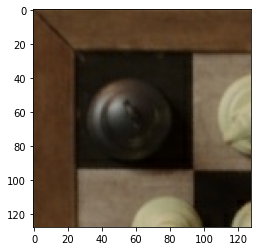

tf.Tensor(
[12 12  8  9 11 12 12 12 10 12 11  8  6  9 12 12  7 12 12 11 12  5  7 12
 12 12  1 12 12  5 12  5  7  5  8  3  1 12 10  3 12 12  0  5 12 12 12 12
 10 12 10 10  5 11  7 12 11  2  8  7  3 12  0  3], shape=(64,), dtype=int64)


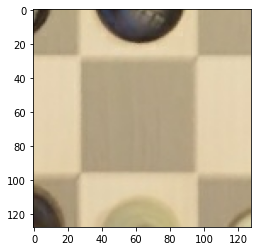

tf.Tensor(12, shape=(), dtype=int64)


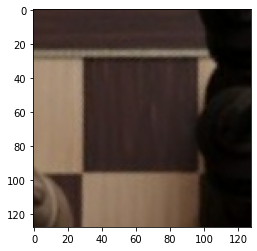

In [57]:
# Testing a TFRecord data pipeline
def formatImg(rawImg):
    image = tf.image.decode_jpeg(rawImg, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]) # explicit size needed for TPU
    
    #Augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image

def decodeTFRec(record_):
    features = {
        "img" : tf.io.FixedLenFeature([], tf.string),
        "classId" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record_, features)
    img = formatImg(example["img"])
    label = example["classId"]
    return img, label

def makeTFRecordsDataset(recordsPaths_):
    dataset = tf.data.TFRecordDataset(recordsPaths_)
    dataset = dataset.map(decodeTFRec, num_parallel_calls = tf.data.AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

#datasetSize = 16000
trainSize = int(datasetSize * TRAIN_PROPORTION)
valSize = int(datasetSize * VAL_PROPORTION)
testSize = int(datasetSize * TEST_PROPORTION)

trainValSepPoint = trainSize + valSize
valTestSepPoint = trainValSepPoint + testSize

# Building datasets
recordsPaths = [os.path.join(TF_RECORDS_FOLDER, filepath) for filepath in os.listdir(TF_RECORDS_FOLDER)]
trainDs = makeTFRecordsDataset(recordsPaths[0:trainSize])
valDs = makeTFRecordsDataset(recordsPaths[trainSize:trainValSepPoint])
testDs = makeTFRecordsDataset(recordsPaths[trainValSepPoint:valTestSepPoint])
recordsPaths = None

print("Created sets with the following sizes : training ({}), validation ({}), test ({})".format(trainSize, valSize, testSize))

if True:
    # Checking if everything looks to have loaded normally
    img, classId = next(iter(trainDs))
    print(classId)
    plt.figure()
    plt.imshow(img[0])
    plt.show()

    img, classId = next(iter(valDs))
    print(classId)
    plt.figure()
    plt.imshow(img[0])
    plt.show()

    img, classId = next(iter(testDs))
    print(classId[0])
    plt.figure()
    plt.imshow(img[0])
    plt.show()


# Model Setup and Training

## Set classes weights

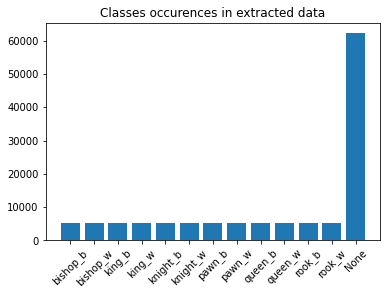

In [ ]:
# Graph for better visualization of class imbalance
classesInDataset = []
classesOccurences = []
for className in typesOccurences:
    classNameStr = str(className)
    classesInDataset.append(classNameStr)
    classesOccurences.append(typesOccurences[className])

plt.bar(classesInDataset, classesOccurences)
plt.xticks(rotation=45)
plt.title("Classes occurences in extracted data")
plt.show()

# We create classes weights invertly proportional to the frequency of the class in the dataset, and then scale them according to a reference class weight
datasetSize = sum(classesOccurences)
classWeights = {piecesTypes.index(className):datasetSize/typesOccurences[className] for className in typesOccurences}
# Picking a reference class whose weight is going to be 1
weightsScalingFactor = 1.0/classWeights[0]
classWeights = {className:classWeights[className]*weightsScalingFactor for className in classWeights}

## Building the model architecture

### Model architecture

In [20]:
# Loading pretrained layer
#pretrainedLayer = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling="max")
#pretrainedLayer = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling="max")
#pretrainedLayer = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),pooling="max")
pretrainedLayer = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),include_top=False,weights="imagenet",pooling="max")
pretrainedLayer.trainable = True
pretrainedLayer.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [21]:
# Early stopping setup
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3)

# Model building
model = tf.keras.Sequential()

model.add(pretrainedLayer)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(len(piecesTypes), name="output", activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output (Dense)              (None, 13)                6

## Training

In [ ]:
def trainModel():
  history = None
  with tf.device("/device:GPU:0"):
    history = model.fit(trainDs, 
                        epochs = 20, 
                        validation_data = valDs, 
                        callbacks=[callback], 
                        class_weight=classWeights)
  return history

history = None
history = trainModel()

Epoch 1/20
1361/1361 [==============================] - 326s 235ms/step - loss: 0.2015 - sparse_categorical_accuracy: 0.9230 - val_loss: 2.3300 - val_sparse_categorical_accuracy: 0.5551
Epoch 2/20
1361/1361 [==============================] - 324s 238ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7942
Epoch 3/20
1361/1361 [==============================] - 318s 234ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.9313
Epoch 4/20
1361/1361 [==============================] - 322s 236ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9819 - val_loss: 2.2588 - val_sparse_categorical_accuracy: 0.6863
Epoch 5/20
1361/1361 [==============================] - 316s 232ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.4225 - val_sparse_categorical_accuracy: 0.9047
Epoch 6/20
1361/1361 [==============================] - 316s 232ms/ste

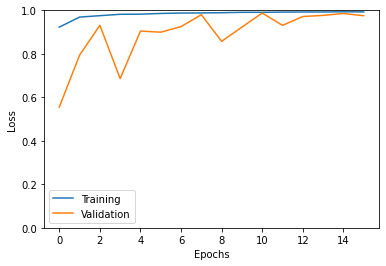

In [ ]:
plt.plot(np.array(history.history['sparse_categorical_accuracy']))
plt.plot(np.array(history.history['val_sparse_categorical_accuracy']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(ymax = 1.0, ymin = 0.0)
plt.legend(["Training", "Validation"])
plt.show()

## Testing on the test dataset

### Creating confusion matrix

In [104]:
confusionMat = np.zeros((len(piecesTypes), len(piecesTypes)), dtype = int)

for img, label in tqdm.tqdm(testDs):
  preds = np.argmax(model.predict(img), axis=1)

  for i in range(len(preds)):
    confusionMat[label[i]][preds[i]] += 1

print(confusionMat)

292it [00:18, 15.68it/s]

[[ 782    0    0    0    1    0    5    0    0    0    0    2    0]
 [   8  729    0    8    0    2    0    2    0    1    0    1    0]
 [   7    0  722    2    0    0    1    0    0    0    0    0    0]
 [   0    0    3  780    0    2    0    0    0    0    0    0    0]
 [   5    0    4    0  740    1    2    0    0    0    0    2    0]
 [   0    1    0    4   16  792    0    0    0    0    0    1    0]
 [   5    0    0    0    1    0  798    1    0    0    0    0    0]
 [   1   21    0    0    1    0   12  737    0    0    0    0    0]
 [  54    0    4    0    0    0    0    0  706    0    2    2    0]
 [   0   20    1   26    0    0    0    1    2  750    0    7    0]
 [   2    0    2    1    0    0    4    0    0    0  749    0    0]
 [   0    0    0    0    0    0    0    0    0    0    8  748    0]
 [  30   11   23   52   20   35    5    1    2    4    8   16 9153]]


In [64]:
print(confusionMat)
print(piecesTypes)
totalPreds = confusionMat.sum()
goodPreds = sum(np.diag(confusionMat))
print("Accuracy : {} %".format(np.round(100.0 * goodPreds / totalPreds, 3)))

[[ 780    1    1    0    0    0    6    0    0    0    0    2    0]
 [   9  730    0    9    0    1    0    1    0    0    0    1    0]
 [   6    0  725    1    0    0    0    0    0    0    0    0    0]
 [   0    0    2  782    0    1    0    0    0    0    0    0    0]
 [   1    0    1    0  747    1    1    0    0    0    1    2    0]
 [   1    2    0    6   11  793    0    0    0    0    0    1    0]
 [   8    0    1    0    2    0  793    1    0    0    0    0    0]
 [   1   18    0    0    0    1   12  738    0    2    0    0    0]
 [  56    0    6    0    2    0    0    0  701    0    1    2    0]
 [   1   14    1   32    0    1    0    1    3  749    0    5    0]
 [   4    0    1    0    1    0    3    0    0    0  748    1    0]
 [   0    0    0    2    0    1    0    0    0    0    9  744    0]
 [  22   13   26   46   29   35    3    4    0    3    6   17 9156]]
['bishop_b', 'bishop_w', 'king_b', 'king_w', 'knight_b', 'knight_w', 'pawn_b', 'pawn_w', 'queen_b', 'queen_w', 'roo

## Testing on a real-world conditions image

In [170]:
imgNum = 5
imgPath = getRawImagePath(imgNum)
annotationsPath = getImageConfigPath(imgNum)

annotations = json.load(open(annotationsPath, "r"))

sceneImg = cv2.imread(imgPath)
sceneImg = cv2.cvtColor(sceneImg, cv2.COLOR_BGR2RGB)

boardImage = getUnwrappedBoardImg(sceneImg, annotations)
boardImgSize = tuple(boardImage.shape[0:2])

boardPredictedPositions = {}
boardRealPositions = {}
piecesImages = np.zeros((64,IMAGE_SIZE,IMAGE_SIZE,3))
# Extracting the cell images
for cellName in cellsCoordinates:
    cellIdx = cellsNames.index(cellName)
    cellCoords = cellsCoordinates[cellName]
    cellBoundsRel = getCellBoundingBoxRel(cellCoords[0], cellCoords[1])
    cellBoundsAbs = np.round(np.multiply(cellBoundsRel.T, boardImgSize)).astype(int)

    pieceImg = boardImage[cellBoundsAbs[0,0]:cellBoundsAbs[0,1],cellBoundsAbs[1,0]:cellBoundsAbs[1,1]]
    pieceType = None if (not (cellName in annotations["config"])) else annotations["config"][cellName]

    pieceImgNorm = np.array(pieceImg)
    pieceImgNorm = pieceImgNorm / 255.0
    
    piecesImages[cellIdx] = pieceImgNorm
    
    boardRealPositions[cellName] = pieceType

preds = np.argmax(model.predict(piecesImages), axis=1)
for cellName in cellsCoordinates:
    cellIdx = cellsNames.index(cellName)
    boardPredictedPositions[cellName] = piecesTypes[preds[cellIdx]]

confMat = np.zeros((13,13), dtype=int)
for cellName in cellsCoordinates:
    predIdx = piecesTypes.index(boardPredictedPositions[cellName])
    realIdx = piecesTypes.index(boardRealPositions[cellName])
    confMat[realIdx][predIdx] += 1
print("Confusion matrix : \n", confMat)
totalPreds = np.sum(confMat)
goodPreds = np.sum(np.diag(confMat))
print("Accuracy : {} ({} error(s))".format(goodPreds/totalPreds, totalPreds - goodPreds))

Confusion matrix : 
 [[ 2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 34]]
Accuracy : 1.0 (0 error(s))


### Plotting the predicted & real chess boards

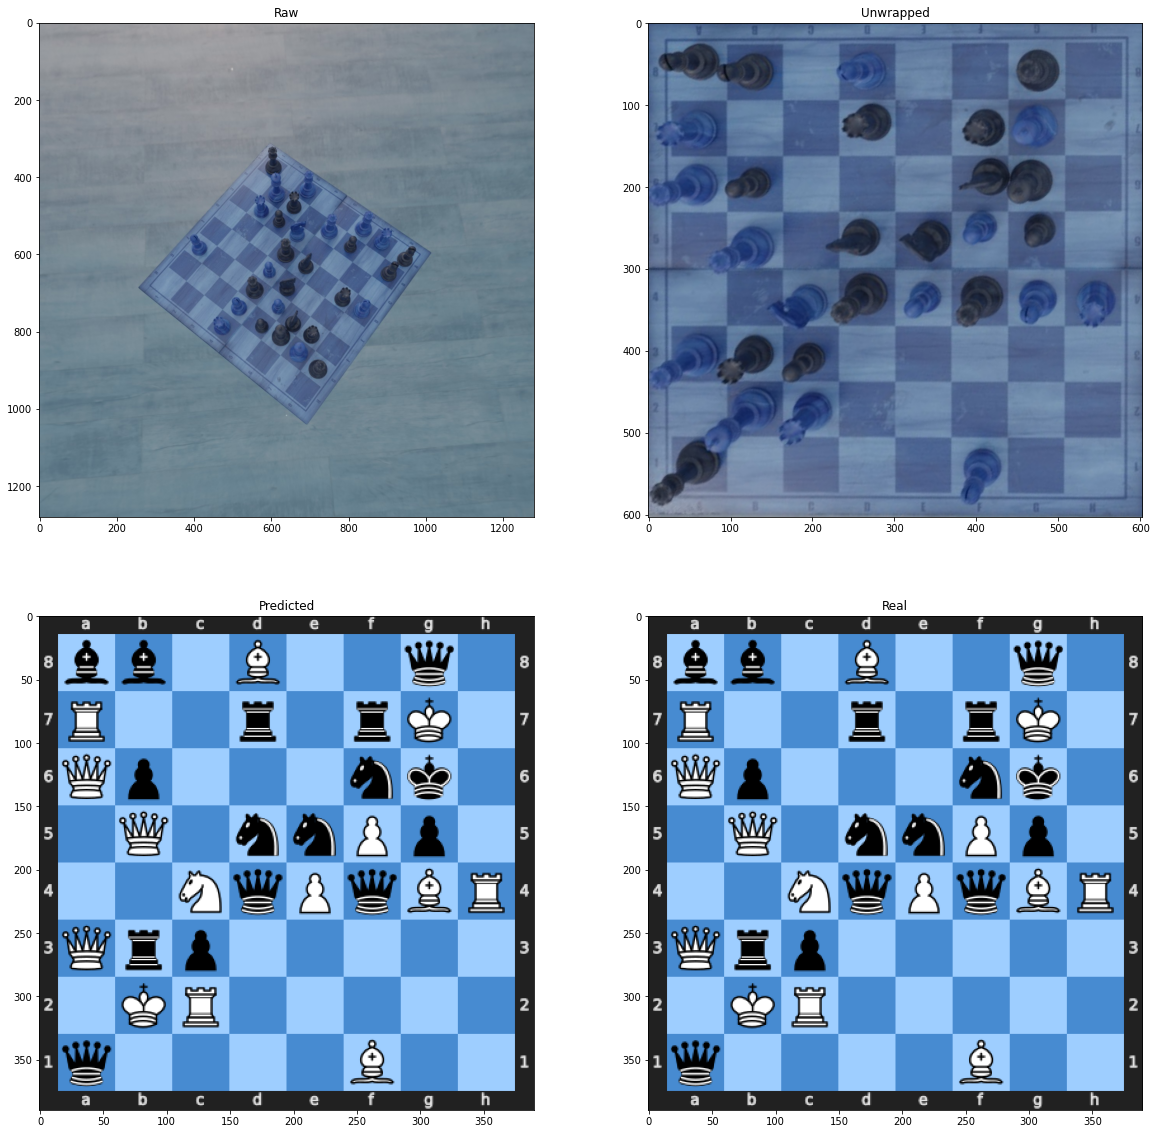

True

In [178]:
import chess
import chess.svg
from cairosvg import svg2png

piecesObjects = {
    "pawn_w" : chess.Piece(chess.PAWN, True),
    "pawn_b" : chess.Piece(chess.PAWN, False),
    "knight_w" : chess.Piece(chess.KNIGHT, True),
    "knight_b" : chess.Piece(chess.KNIGHT, False),
    "bishop_w" : chess.Piece(chess.BISHOP, True),
    "bishop_b" : chess.Piece(chess.BISHOP, False),
    "rook_w" : chess.Piece(chess.ROOK, True),
    "rook_b" : chess.Piece(chess.ROOK, False),
    "queen_w" : chess.Piece(chess.QUEEN, True),
    "queen_b" : chess.Piece(chess.QUEEN, False),
    "king_w" : chess.Piece(chess.KING, True),
    "king_b" : chess.Piece(chess.KING, False),
    None : None
}

boardPred = chess.Board()
boardPred.clear()
boardReal = chess.Board()
boardReal.clear()

for cellName in cellsNames:
    chessSquare = chess.parse_square(cellName.lower())
    boardPred.set_piece_at(chessSquare, piecesObjects[boardPredictedPositions[cellName]])
    boardReal.set_piece_at(chessSquare, piecesObjects[boardRealPositions[cellName]])

rawImg = cv2.cvtColor(sceneImg, cv2.COLOR_BGR2RGB)
unwrappedImg = cv2.cvtColor(cv2.rotate(boardImage, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE), cv2.COLOR_BGR2RGB)
predBoardImg = cv2.cvtColor(np.array(tf.image.decode_png(svg2png(chess.svg.board(boardPred)))), cv2.COLOR_BGR2RGB)
realBoardImg = cv2.cvtColor(np.array(tf.image.decode_png(svg2png(chess.svg.board(boardReal)))), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
axs[0][0].set_title("Raw")
axs[0][0].imshow(rawImg)
axs[0][1].set_title("Unwrapped")
axs[0][1].imshow(unwrappedImg)
axs[1][0].set_title("Predicted")
axs[1][0].imshow(predBoardImg)
axs[1][1].set_title("Real")
axs[1][1].imshow(realBoardImg)
plt.show()

cv2.imwrite("testBoard_raw.jpg", rawImg)
cv2.imwrite("testBoard_unwrapped.jpg", unwrappedImg)
cv2.imwrite("testBoard_pred.jpg", predBoardImg)

In [62]:
model = tf.keras.models.load_model('weights.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 13)               